## 20190211 Data Challenge 1: Predicting oncogenic status of breast tissue clumps
## Time limit: 4 hours
### Data Source: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original)

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)
12. Group (8 sequential cohorts of sampling from 1989 through 1991- added to original data set)

### Goal: 
- Train an algorithm to classify malignant vs. benign breast tissue biopsies with high accuracy, recall, and precision

### Strategy:
- Respect 4-hour full-project time limit
- Data download, cleanup, and group variable joining
- Data visualization - should group be included? Which features appear to be influential? Which features covary?
- Split data 60/20/20 train/validate/test
- Metrics: Accuracy (how often was the algorithm correct? TP+TN/all results), Recall (how rarely did the algorithm miss a positive diagnosis? TP/TP+FN), and Precision (how rarely did the algorithm cry wolf? TP/TP+FP)
- Background review: Under what conditions do the various ML classifiers perform best? 
- Selected multi-layer perceptron classifier neural net, which tolerates non-linear relationships between the features and outcomes, and also covariance of the features
- Trained MLPClassifier (Scikit Learn) first in default state, and then with tunning of neural net structure

### Outcome:
- Excellent Precision - the algorithm never cried wolf
- Relatively poor Recall - the algorithm missed 2 out of 24 positive cases in the test/hold-out set
- Depending on the use case, this outcome may be far from or close to optimal - there's a trade-off between missing some cases in their early stages (false negatives) and over-treating false positives - an ideal algorithm would do neither

### Follow-Up (What I'd like to have done differently):
- In the future, I will use a cross-validation approach with train/validate pool, to allow more universal tuning before breaking out the test/hold-out data set
- During that process, I can adjust threshold to bias the algorithm towards positive response - recall on test/hold-out set was lower than I would have liked, but perfect with the validation set, and so I didn't toggle the threshold
- I should also more explicitly consider imbalanced classes, which may have contributed to the low recall relative to precision - there was more of a chance for the algorithm to train to precision than to train to recall
- Apparently there are duplicated rows of data in this set of ~700, which I did not catch - I should be more careful to screen for duplicate rows in the future

In [109]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

### First import data without group information:

In [131]:
#import data from online repository:
cancer = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data",
              names=["id","clump_thickness","cell_size_uniformity","cell_shape_uniformity",
                    "marginal_adhesion","single_epithelial_cell_size","bare_nuclei","bland_chromatin",
                    "normal_nucleoli","mitoses","class"])

In [135]:
#create an empty column to hold collection cohort "group"
#group may be important, because a lot of variance may exist within cohort, and the algorithm can't account...
#... for this variance without having "group" labeled as a sort of random effect (but fixed in this use)
cancer['group'] = 0

In [136]:
#data is sequentially ordered by date, so this approach can be used:
cancer.iloc[0:367,11]=1 #367 in group 1
cancer.iloc[367:437,11]=2 #70 in group 2
cancer.iloc[437:468,11]=3 #31 in group 3
cancer.iloc[468:485,11]=4 #17 in group 4
cancer.iloc[485:533,11]=5 #48 in group 5
cancer.iloc[533:582,11]=6 #49 in group 6
cancer.iloc[582:613,11]=7 #31 in group 7
cancer.iloc[613:699,11]=8 #86 in group 8
cancer['group'].value_counts(sort=False) #this checks for the desired outcome

1    367
2     70
3     31
4     17
5     48
6     49
7     31
8     86
Name: group, dtype: int64

### Checked some of my assumptions about the data, and deleted the NaN-containing rows
### That lost me 16/700 samples, which I can live with

In [137]:
cancer.shape #shape of df at this stage

(699, 12)

In [138]:
cancer.describe(include='all').loc['unique', :] #indicates that bare_nuclei has non-numeric data

id                             NaN
clump_thickness                NaN
cell_size_uniformity           NaN
cell_shape_uniformity          NaN
marginal_adhesion              NaN
single_epithelial_cell_size    NaN
bare_nuclei                     11
bland_chromatin                NaN
normal_nucleoli                NaN
mitoses                        NaN
class                          NaN
group                          NaN
Name: unique, dtype: object

In [139]:
cancer['bare_nuclei'].unique() #looks like those are question marks

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [140]:
cancer['bare_nuclei'] = cancer['bare_nuclei'].str.replace(pat='?',repl='')
cancer.replace('',np.nan,inplace=True)
cancer['bare_nuclei'].unique() #check to make sure previous command weeded out the ? marks

array(['1', '10', '2', '4', '3', '9', '7', nan, '5', '8', '6'],
      dtype=object)

In [141]:
cancer['bare_nuclei'].unique() #replace question marks with NaNs
cancer.isna().sum() #good, that worked, now they're NaNs

id                              0
clump_thickness                 0
cell_size_uniformity            0
cell_shape_uniformity           0
marginal_adhesion               0
single_epithelial_cell_size     0
bare_nuclei                    16
bland_chromatin                 0
normal_nucleoli                 0
mitoses                         0
class                           0
group                           0
dtype: int64

In [143]:
#now get rid of any rows with NaNs, and set drop_nuclei from "object" to "integer":
cancer = cancer.dropna(axis=0,how='any')
cancer.bare_nuclei=cancer.bare_nuclei.astype(int) #python disliked ['bare_nuclei'] for this purpose
cancer.dtypes #to check that it worked - bare_nuclei should be an int64, not an object

id                             int64
clump_thickness                int64
cell_size_uniformity           int64
cell_shape_uniformity          int64
marginal_adhesion              int64
single_epithelial_cell_size    int64
bare_nuclei                    int64
bland_chromatin                int64
normal_nucleoli                int64
mitoses                        int64
class                          int64
group                          int64
dtype: object

In [144]:
#check back in on the shape to see how many rows/samples we lost - it's 16:
cancer.shape

(683, 12)

In [145]:
#I did not do this, but I should have:
cancer.duplicated(subset=None, keep='first').sum()
#that's 8 duplicated rows! booooo

8

### Plotted the data to see which variables do and do not appear to have a relationship with the response variable ("malignant/benign"); this step determines which features stay and which go

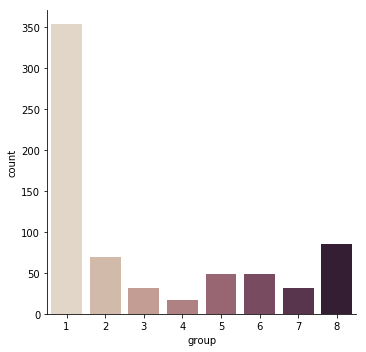

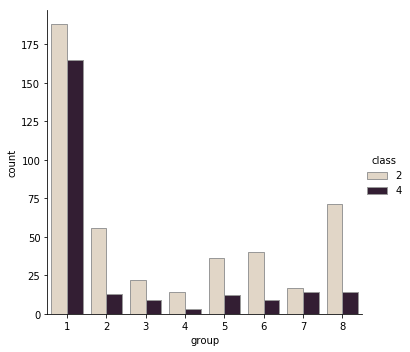

In [146]:
#should we be worried about a batch effect, or do the batches contribute ~equally to the data set?
sns.catplot(x="group", kind="count", palette="ch:.25", data=cancer)
#we should be worried - batch 1 could hold a lot of sway!

#do the batches differ in their proportional samples of positives and negatives?
sns.catplot(x="group", hue="class", kind="count",
            palette="ch: .25", edgecolor=".6",
            data=cancer)
#yeah they do - definitely include batch as a feature in the model
#otherwise any batch-1 specific characteristics would disproportionately describe the benign class
#but not because the benign class disproportionately has those characteristics, rather because batch 1 does

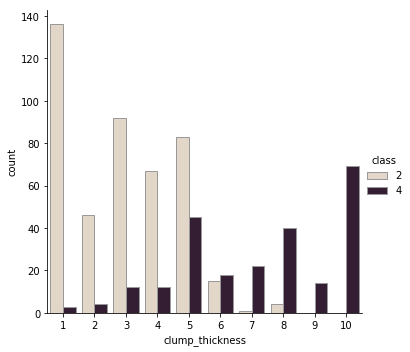

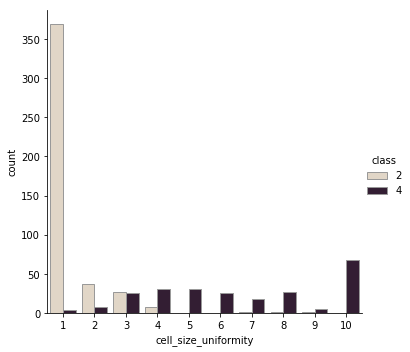

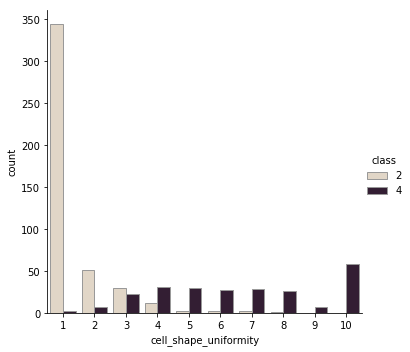

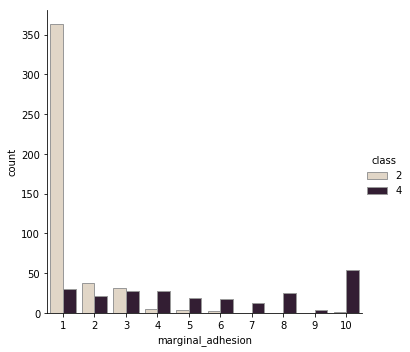

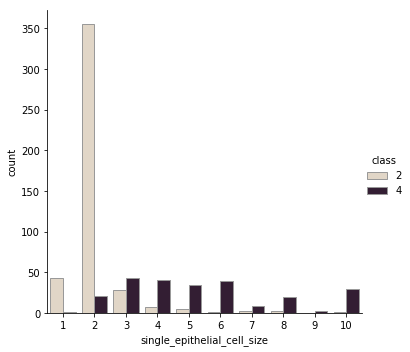

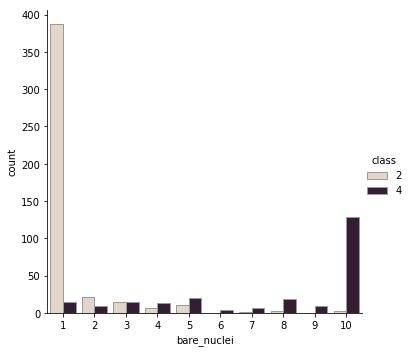

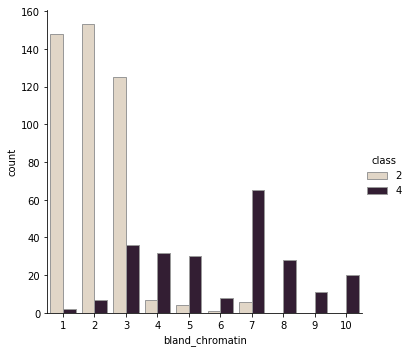

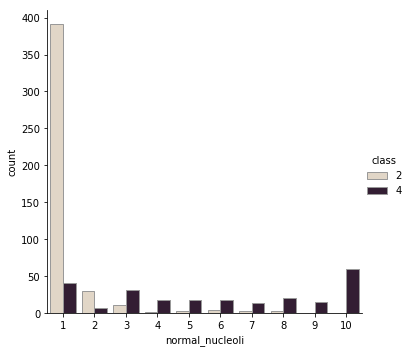

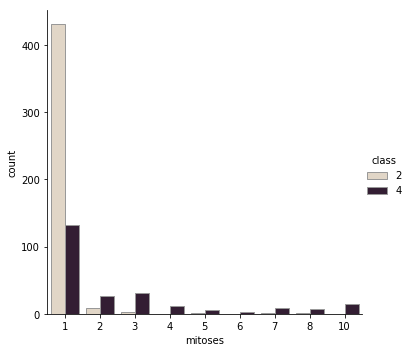

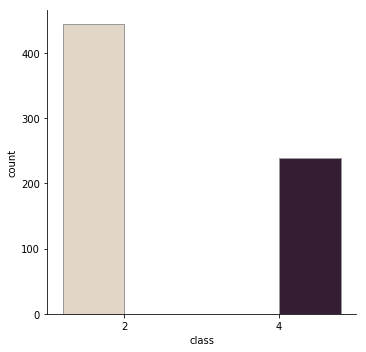

In [147]:
#generate plots to check to see if each feature appears predictive:
trunc_cancer = cancer.drop(['id','group'],axis=1)
for feature in list(trunc_cancer):
    viz = sns.catplot(x=feature, hue="class", kind="count",palette="ch: .25", edgecolor=".6",data=cancer)
    viz.set(xlabel=feature)
    plt.show()
#all features appear to be predictive

/home/cynthiaorourke/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/cynthiaorourke/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


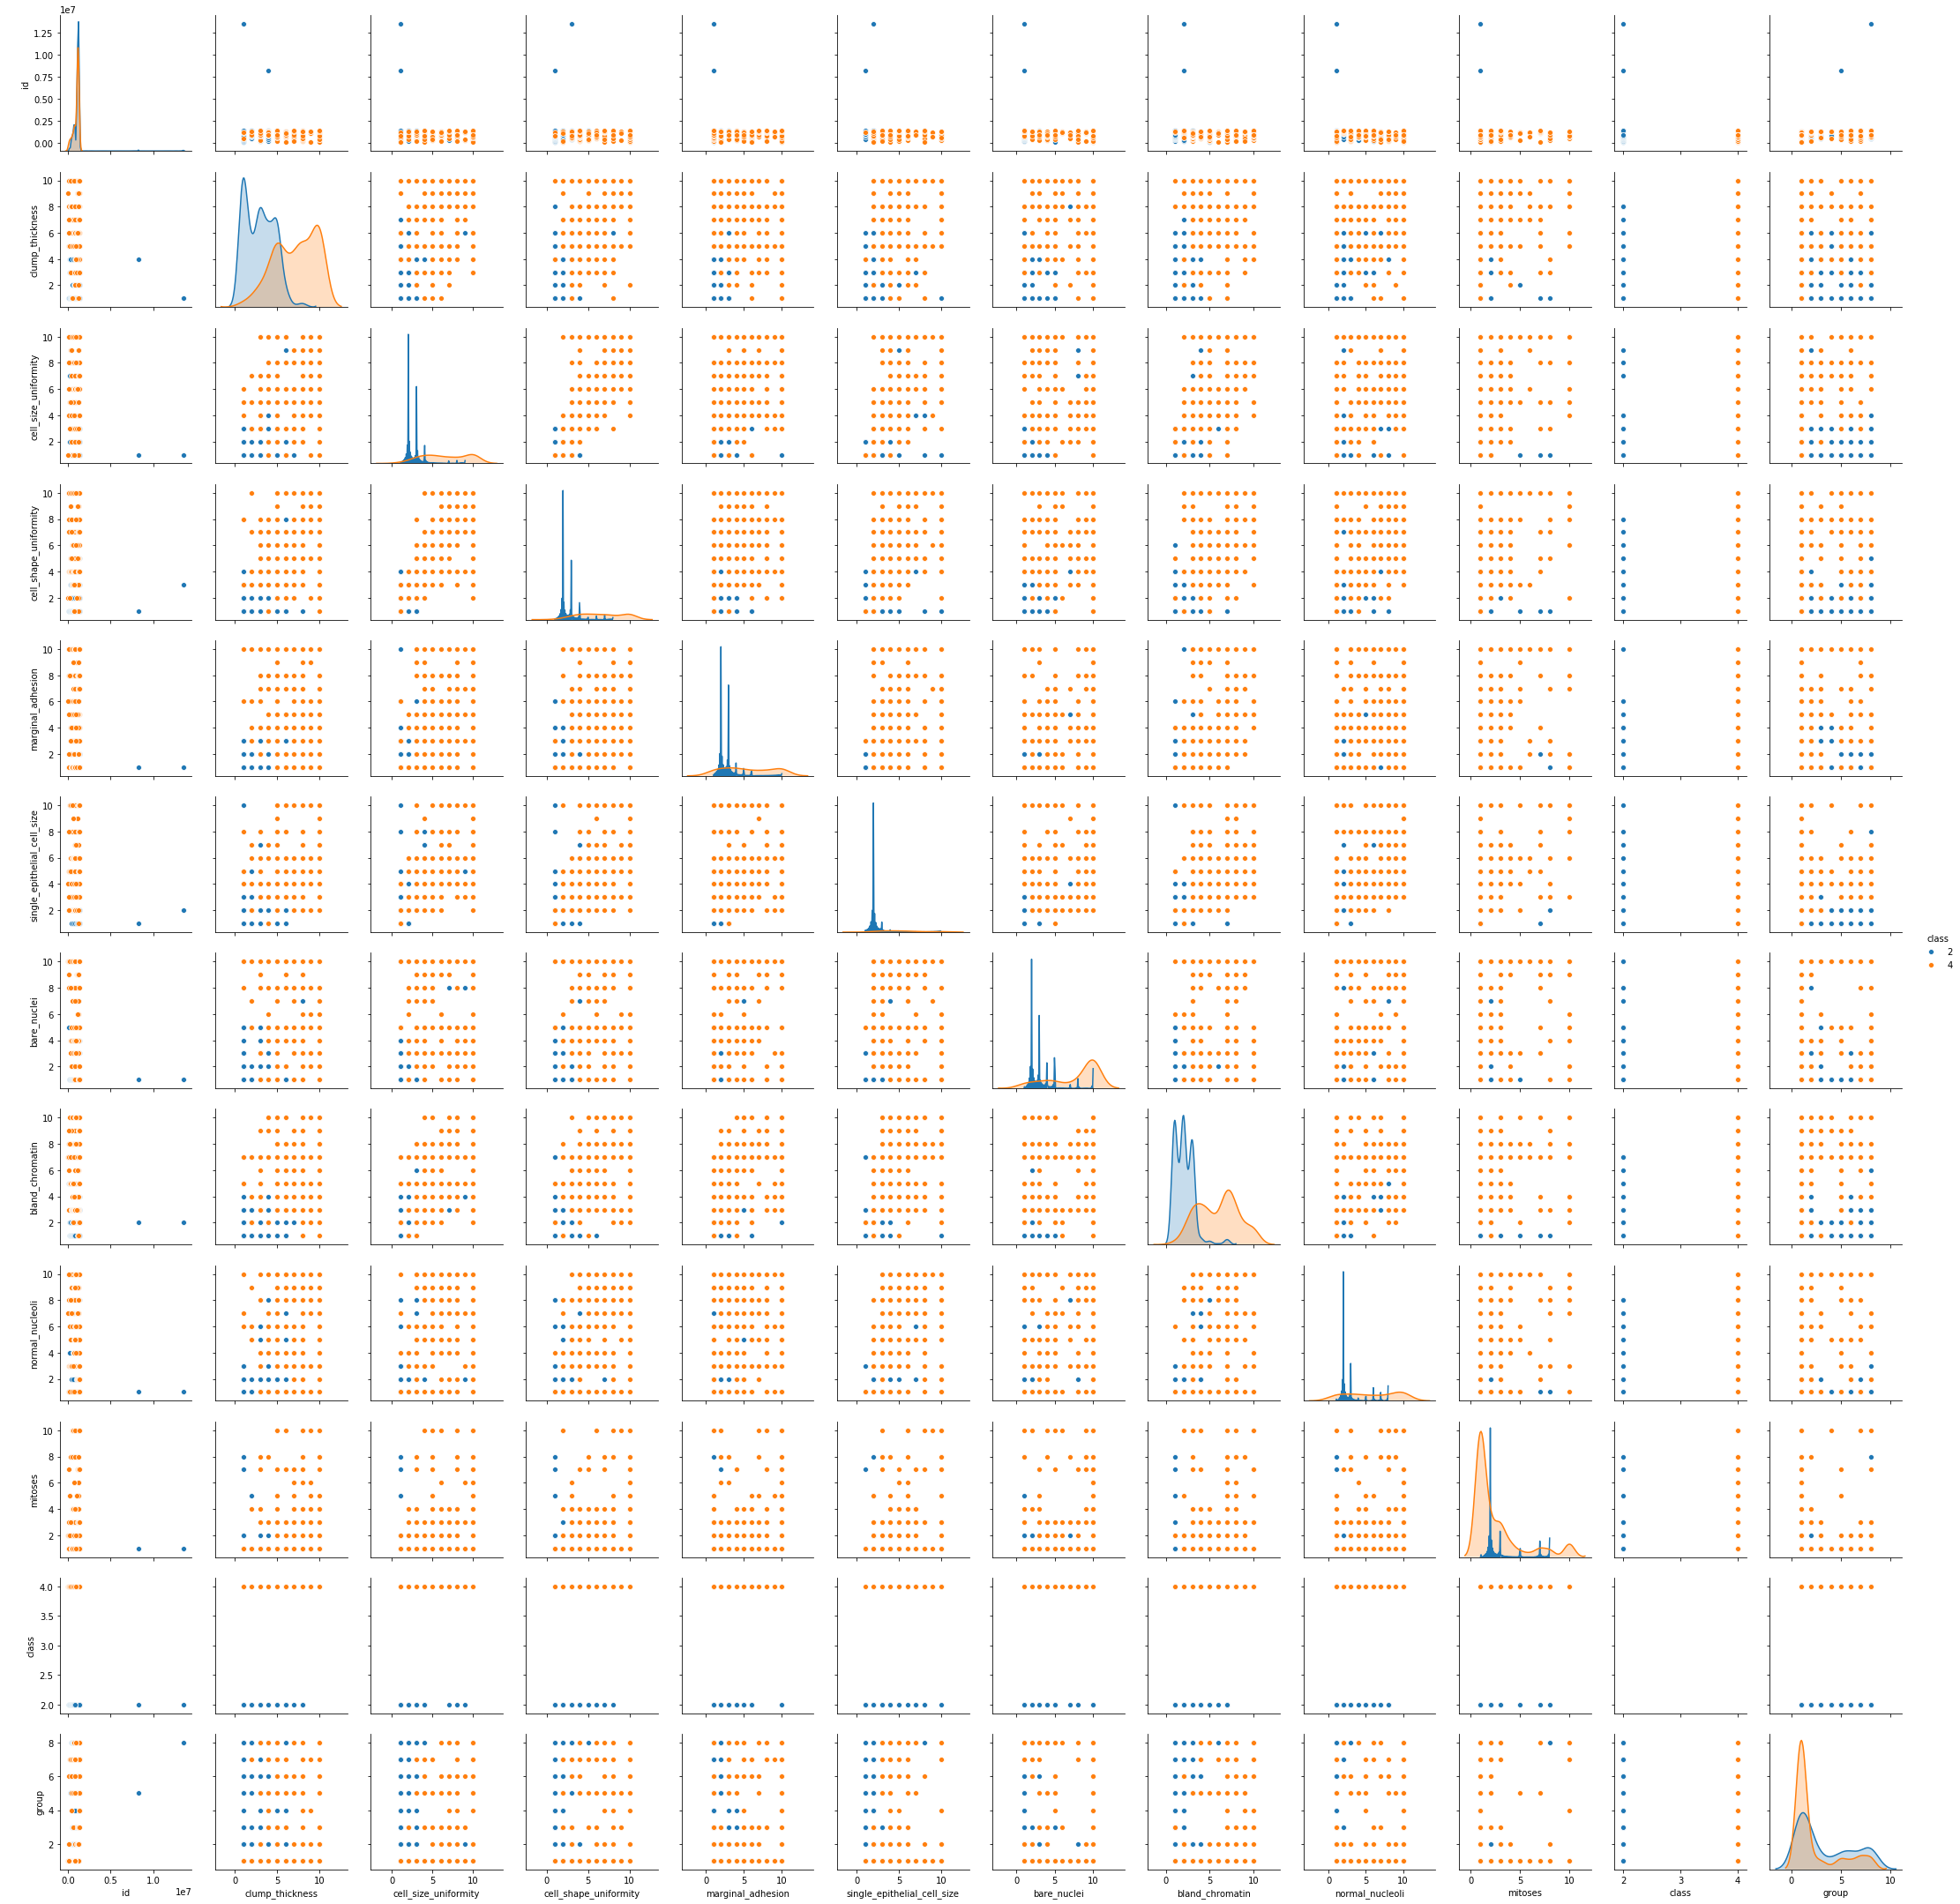

In [149]:
#an alternative approach uses seaborn's pairplot to make pretty but tiny plots:
sns.pairplot(cancer,hue='class')

#malignant is 4, so that's orange
#everything except group and ID looks like it might contain predictive value
#retain all for right now, but note apparent high correlation between many 
#group and ID will be cut later, because of their lack of apparent effect

### Checked the features for correlations, which will determine what kind of model I can use without preprocessing or some sort of variable collapse, like PCA or Lasso

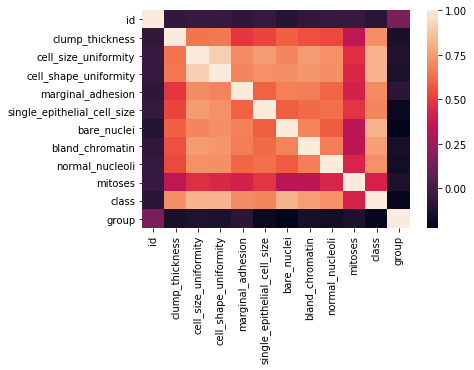

In [150]:
corr=cancer.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
#yes, almost everything is highly correlated
#Salchenberger, Cinar, and Lash [29] reported that the neural network model performs well when 
#multicollinearity is present and a nonlinear relationship exists between the input and the output variables.

### Split the data into a 60% train, 20% validate, 20% test set
- In retrospect I may have been better off with a 70% 15% 15% split - validated model did not perform perfectly on the test/hold-out data
- Also start importing additional sklearn functions below, such as label binarizer to replace those 2/4 values with 0/1 values, and precision_recall_curve and confusion_matrix for model testing

In [151]:
#before going any further, make a train/validate/test split
#Andrew Ng suggests 60/20/20 and that guy is pretty good at this stuff, so that's what I'm going to do:
import sklearn
from sklearn.model_selection import train_test_split

In [152]:
#this allows me to turn those 2s and 4s into 0s and 1s:
from sklearn.preprocessing import LabelBinarizer
#this imports a lot of useful sklearn diagnostics, not all of which I actually end up using:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [154]:
#turn 2s into 0s and 4s into 1s:
lb = LabelBinarizer()
cancer['class'] = lb.fit_transform(cancer['class'].values)
targets = cancer['class']

#create a df of only desired features, no labels:
X = cancer.drop(['id','class'],axis=1)
#leaving group as ordinal value in there - it may be important/informative, judging by plot above

#create an array of only labels, no features:
y = cancer['class']

In [155]:
#data is order sequentially, so particularly important to use a randomizing train/test/split function:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [156]:
#check to make sure it worked:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape) #ok, good

(546, 10) (546,) (68, 10) (68,) (69, 10) (69,)


In [157]:
#check to make sure that the sorting is in fact pretty random:
print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))
#cool cool cool - these seem to have been successfully randomized with respect to at least the label

y_train class distribution
0    0.648352
1    0.351648
Name: class, dtype: float64
y_test class distribution
0    0.647059
1    0.352941
Name: class, dtype: float64


### Did some reading to determine that a neural net model is appropriate for the classification situation that we have here - multicollinearity (check) and a nonlinear relationship between all of these ordinal features and the binomial response variable:

- "A high degree of correlation among independent variables (multicollinearity) will have adverse effects on the parameter estimates of LDA and logistic procedures" - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.87.2314&rep=rep1&type=pdf
- "Salchenberger, Cinar, and Lash [29] reported that the neural network model performs well when multicollinearity is present and a nonlinear relationship exists between the input and the output variables."

### Followed the linked scikit-learn tutorial to run through a default model first:

In [158]:
#following: https://scikit-learn.org/stable/modules/neural_networks_supervised.html

from sklearn.neural_network import MLPClassifier
X = X_train
y = y_train
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X, y)                         
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(5, 2),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
#later I will come back and toggle the neural net structure away from the default hidden_layer_sizes of (5,2)
#5 is the number of hidden layers, 2 is the number of neurons within each layer

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [159]:
#generate predicted y_val values based on the trained classifier and the known X_val values
y_new=clf.predict(X_val) 

In [160]:
#'Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 
#In information retrieval, precision is a measure of result relevancy, 
#while recall is a measure of how many truly relevant results are returned. - sklearn docs

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_new, y_val)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

#first pass, using default (5,2) structure, is 0.84

Average precision-recall score: 0.84


In [161]:
#generate a confusion matrix, either with the default scikit approach:
#sklearn.metrics.confusion_matrix(y_val, y_new, labels=None, sample_weight=None)
#or this other approach, for a nicer version, with labels:
pd.crosstab(y_val, y_new, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,45,1,46
1,3,20,23
All,48,21,69


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.84')

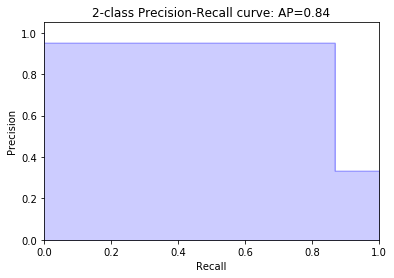

In [162]:
#generate a plot of the trade-off between precision and recall:

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_val, y_new)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

#What does this say? It describes the trade-off that we have between perfect...
#... precision, which is no false positives, and perfect recall, which is no false negatives

### This is the output of my three neural nets, with some bouncing around in the neural structure "hyperparameter space" to see what effects variations on restructuring might have on precision-recall, and on confusion matrix output:

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Average precision-recall score: 0.84.

Drastically increasing the number of neurons (to 30) in each hidden layer (5) has a substantial effect on the Prec-Recall score and curve.
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(5, 30),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
Average precision-recall score: 0.96.

Conversely, just doubling the number of hidden layers (from 5 to 10) broke the model.
Bringing it up from 5 to 7, however, results in a perfect(??) score.
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Average precision-recall score: 1.00
No wait, that's not good, that means it never falsely diagnosed something but also it never diagnosed anything... right? I mean precision minus recall is accuracy minus not-missing-things, yes?
I need a second diagnostic...

...ok, added a confusion matrix and it looks like precision-recall may actually be perfect at 100%?
The model is, at 7 hidden layers and 2 neurons per, perfectly classifying the validation set after being trained, but I still haven't taken it out and tested it on the test set. Would be nice to have one more diagnostic first. Can't easily find one, don't want to spend all night on this, moving on to testing this out on the actual test data.

### Having landed on a neural net that the validation data considers "perfect," I now move on to the test data to see you perfect it really is: 

In [178]:
X = X_train
y = y_train
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(7, 2), random_state=1)

clf.fit(X, y)                         
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(7, 2),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
#one consideration here is that adding additional hidden layers to the neural net may be effective...
#... but computationally expensive, especially on larger scales

y_new=clf.predict(X_val) 
average_precision = average_precision_score(y_new, y_val)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 1.00


In [179]:
#once again generate predictions for the reserved set, based on that set's features and the trained model:
y_new=clf.predict(X_test)

In [180]:
#generate an average precision-recall score:

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_new, y_test)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
#not as good as on the validation data! 
#interesting

Average precision-recall score: 0.92


In [181]:
#generate another one of those nice confusion matrices with the labels:
pd.crosstab(y_test, y_new, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,44,0,44
1,2,22,24
All,46,22,68


- The prec-recall score for the test set is only 0.92, which isn't great, and the confusion matrix reveals an accuracy of (TP+TN)/(TP+FP+TN+FN)=0.97, a precision of (TP)/(TP+FP) = 1.00, and a recall of (TP)/(TP+FN) = 91.7%.
- The good news is that no one in the test set was unecessarily freaked-out by false positives.
- The bad news is that two people are blissfully unaware that they have cancer. 
- Let's try this approach again with a random forest classifier, below.
- Wait, nope! Three hour mark! Game over. Time to write this up and make slides.

In [131]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}